In [53]:
import pickle
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage
import tifffile
import yaml

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [7]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [16]:
run_dir = '/data/estorrs/mushroom/data/projects/kelsey'

In [17]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [18]:
# fix issues where antibody names aren't consistent accross some images
channel_to_idents = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
    'E-cadherin': ['E-cadherin', 'E-Cadherin'],
    'CD45': ['CD45'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin', 'Vim', 'VIM'],
    'SMA': ['SMA', 'a-SMA'],
    'CD31': ['CD31'],
    'CD20': ['CD20', 'CD20-Akoya'],
    'CD68': ['CD68'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
    'MGP': ['MGP'],
    'CD36': ['CD36'],
    'PR': ['PR'],
    'ER': ['ER'],
    'P21': ['P21'],
    'P16': ['P16'],
    'CK5': ['Keratin 5', 'KRT5', 'CK5'],
    'CK7': ['CK7'],
    'CK8/18': ['CK8/18'],
    'TFF1': ['TFF1'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'KRT14'],
    'CK17': ['CK17', 'Keratin 17', 'CK17'],
    'CK19': ['CK19', 'Keratin 19', 'KRT19'],
    'CD11b': ['CD11b', 'CD11B', 'cd11b'],
    'GATA3': ['GATA3'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
    'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
    'Her2': ['Her2', 'HER2'],
    'Bap1': ['Bap1', 'BAP1'],
    'GLUT1': ['Glut1', 'GLUT1'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR', 'HLADR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN'],
    'CTLA4': ['CTLA4'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3'],
    'PTPRZ1': ['PTPRZ1'],
    'HIF1A': ['HIF1a', 'HIF1A'],
    'PAI1': ['PAI1'],
    'GFAP': ['GFAP'],
    'VEGFA': ['VEGFA'],
    'IBA1': ['IBA1'],
    'OLIG2': ['OLIG2'],
    'FN1': ['FN1'],
    'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
    'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
    'Granzyme-B': ['Granzyme B', 'GZMB'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1', 'PD1'],
    'PDL1': ['PD-L1', 'PDL1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63', 'p63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1', 'LYVE1'],
    'CCL2': ['CCL2'],
    'MUC2': ['MUC2'],
    'SOX9': ['SOX9'],
    'STEAP4': ['STEAP4'],
    'AR': ['AR'],
    'AMACR': ['AMACR'],
    'PGC': ['PGC', 'PGC (D)'],
    'CFTR': ['CFTR (D)', 'CFTR'],
    'REG3A': ['REG3A (D)', 'REG3A'],
    'LAMC2': ['LAMC2 (D)', 'LAMC2'],
    'INS': ['INS (D)', 'INS'],
    'CRP': ['CRP (D)', 'CRP'],
    'CD74': ['CD74 (D)', 'CD74'],
    'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
    'AQP1': ['AQP1'],
    'AQP2': ['Aqp2', 'AQP2'], 
    'LRP2': ['LRP2'],
    'UMOD': ['UMOD'],
    'CALB1': ['CALB1'],
    'CP': ['CP'],
    'CA9': ['CA9'],
    'UCHL1': ['UCHL1'],
}
channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# add in (D) variants
variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
channel_mapping.update({k + variant:v
                      for k, v in channel_mapping.items()
                      for variant in variants})

In [22]:
case = 'SN001H1-Md1Fp2b'

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
target_res = 50

In [20]:
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registered/s0_SN001H1-Md1Fp2b-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'SN001H1-Md1Fp2b-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registered/s1_SN001H1-Md1Fp2b-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'SN001H1-Md1Fp2b-U2'}],
 'target_sid': 'SN001H1-Md1Fp2b-U1'}

In [27]:
config = deepcopy(DEFAULT_CONFIG)

config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': target_res,
        'out_dir': os.path.join(run_dir, case, f'mushroom_{target_res}res'),
        'accelerator': 'gpu',
        'steps_per_epoch': 1000,
        'data_mask': None,
    },
    'sae_kwargs': {
        'neigh_scaler': 0.01
    }
})

config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
        'multiplex': {
            'trainer_kwargs': {
                'channel_mapping': channel_mapping
            }
        }
    }
)
config = alter_filesystem(config, source_root, target_root)
config

{'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registered/s0_SN001H1-Md1Fp2b-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'SN001H1-Md1Fp2b-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registered/s1_SN001H1-Md1Fp2b-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'SN001H1-Md1Fp2b-U2'}],
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}},
  'multiplex': {'trainer_kwargs': {'channel_mapping': {'Pan-Cytokeratin': 'Pan-Cytokeratin',
     'Pan-CK': 'Pan-Cytokeratin',
     'PanCK': 'Pan-Cytokeratin',
     'PanCytokeratin': 'Pan-Cytokeratin',
     'E-cadherin': 'E-cadherin',
     'E-Cadherin': 'E-cadherin',
     'CD45': 'CD45',
     'CD45RO': 'CD45RO',
     'CD45RA': 'CD45RA',
     'CD8': 'CD8',
     'CD8a': 'CD8',
     'DAPI': 'DAPI',
     'CD4': 'CD4',
     'CD3e': 'CD3e',
     'C

In [28]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 25 channels
INFO:root:2 sections detected: ['SN001H1-Md1Fp2b-U2', 'SN001H1-Md1Fp2b-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section SN001H1-Md1Fp2b-U2


0.02


INFO:root:generating image data for section SN001H1-Md1Fp2b-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('SN001H1-Md1Fp2b-U2', 'multiplex'), ('SN001H1-Md1Fp2b-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpjclr1sei
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpjclr1sei/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


multiplex torch.Size([25, 202, 181])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:2 sections detected: ['SN001H1-Md1Fp2b-U1', 'SN001H1-Md1Fp2b-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section SN001H1-Md1Fp2b-U1


50 grid (243768, 477)
(243768, 2)
[ 9046 10080]


INFO:root:generating image data for section SN001H1-Md1Fp2b-U1_dup


50 grid (243768, 477)
(243768, 2)
[ 9046 10080]


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('SN001H1-Md1Fp2b-U1', 'xenium'), ('SN001H1-Md1Fp2b-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


xenium torch.Size([477, 203, 182])


In [29]:
mushroom.train()

INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/kelsey/mushroom_50res/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.914    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/kelsey/mushroom_50res/multiplex_chkpts/last.ckpt
INFO:root:starting training for xenium
Missing logger folder: /data/estorrs/mushroom/data/projects/kelsey/mushroom_50res/xenium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.991    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/kelsey/mushroom_50res/xenium_chkpts/last.ckpt


In [30]:
mushroom.embed_sections()

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [31]:
out_dir = mushroom.trainer_kwargs['out_dir']
fig_dir = os.path.join(out_dir, 'figures')
Path(fig_dir).mkdir(parents=True, exist_ok=True)

INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume


0


INFO:root:merging cluster volumes
INFO:root:constructing graph with 1936 edges
INFO:root:306 edges remaining after filtering
INFO:root:44 of 44 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 5 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 68, 71, 72, 74, 76, 79, 80, 81, 83, 85, 87, 88, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 17 glyp

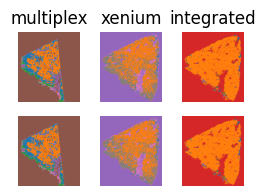

INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore


1


INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 40401 edges
INFO:root:7909 edges remaining after filtering
INFO:root:201 of 201 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 7 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 68, 71, 72, 74, 76, 79, 80, 81, 83, 85, 87, 88, 91]
INFO:fontTools.su

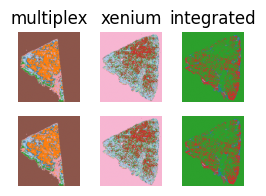

INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore


2


INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 133225 edges
INFO:root:36193 edges remaining after filtering
INFO:root:365 of 365 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 32 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 68, 71, 72, 74, 76, 79, 80, 81, 83, 85, 87, 88, 91]
INFO:fontTools

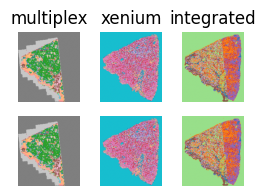

In [34]:
for level, cluster_res in enumerate(cluster_resolutions):
    print(level)
    dtype_to_volume = mushroom.generate_interpolated_volumes(
        z_scaler=z_scaler, level=level, integrate=True, resolution=cluster_res)
    dtype_to_volume_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume.items()}

    mushroom.display_volumes(dtype_to_volume=dtype_to_volume_labels, positions=mushroom.section_positions)

    plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.pdf'), dpi=300)
    plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.png'), dpi=300)
    plt.show()

    pickle.dump({
        'probs': dtype_to_volume,
        'labeled': dtype_to_volume_labels
    }, open(os.path.join(out_dir, f'nbhd_volumes_l{level}.pkl'), 'wb'), protocol=4)

    del(dtype_to_volume)
    del(dtype_to_volume_labels)

clustering_params = {
    'z_scaler': z_scaler,
    'cluster_resolutions': cluster_resolutions,
    'dtype_to_weight': {}
}
yaml.safe_dump(clustering_params, open(os.path.join(out_dir, 'nbhd_volume_params.yaml'), 'w'))

In [35]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/kelsey/mushroom_50res


In [59]:
export_dir = os.path.join(run_dir, case, 'exports')
Path(export_dir).mkdir(parents=True, exist_ok=True)

In [60]:
def save_assigned_nbhds(dtype):
    barcode_outs = os.path.join(export_dir, 'barcodes_to_nbhds')
    Path(barcode_outs).mkdir(parents=True, exist_ok=True)
    spore = mushroom.dtype_to_spore[dtype]
    Path(barcode_outs).mkdir(parents=True, exist_ok=True)
    sids = [x for x, _ in spore.section_ids]
    for sid in sids:
        if dtype in ['xenium', 'visium', 'cosmx']:
            a = spore.learner_data.dtype_to_section_to_adata[dtype][sid]
            pts = a.obsm['spatial']
            df = a.obs[[]]
        elif dtype in ['multiplex']:
            fp = os.path.join(run_dir, case, 'auxiliary', 'multiplex', f'{sid}.txt')
            if os.path.exists(fp):
                df = pd.read_csv(fp, index_col=0, sep='\t')
                df.index.name = 'label'
                df = df[['row', 'col', 'cell_type']]
                pts = df[['col', 'row']].values.astype(int)
            else:
                print(f'no barcodes to map: {fp}')
                pts = None
        else:
            raise RuntimeError(f'dtype {dtype} does not have barcodes to map')
        
        if pts is not None:
            for level in range(mushroom.num_levels):

                labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level)
                df[f'nbhd_level{level}'] = [f'nbhd {x}' for x in labels]

                dtype_to_volume = pickle.load(
                    open(os.path.join(run_dir, case, 'mushroom_50res', f'nbhd_volumes_l{level}.pkl'), 'rb')
                )['labeled']

                for dt, volume in dtype_to_volume.items():
                    labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level, use_volume=True, volume=volume)
                    df[f'nbhd_crossdtype_{dt}_level{level}'] = [f'nbhd {x}' for x in labels]

            df.to_csv(os.path.join(barcode_outs, f'{sid}_{dtype}_barcode_to_nbhds.txt'), sep='\t')

In [61]:
for dtype in ['xenium', 'visium', 'multiplex', 'cosmx']:
    if dtype in mushroom.dtypes:
        save_assigned_nbhds(dtype)

/tmp/ipykernel_1852374/2851756772.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'nbhd_level{level}'] = [f'nbhd {x}' for x in labels]
/tmp/ipykernel_1852374/2851756772.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'nbhd_crossdtype_{dt}_level{level}'] = [f'nbhd {x}' for x in labels]
/tmp/ipykernel_1852374/2851756772.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

no barcodes to map: /data/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/auxiliary/multiplex/SN001H1-Md1Fp2b-U2.txt


In [62]:
data = []
for section in mushroom.sections:
    data.append([
        section['sid'],
        section['position'],
        section['data'][0]['dtype'],
        section['data'][0]['filepath'],
    ])
df = pd.DataFrame(data=data, columns=['section_id', 'position', 'dtype', 'filepath'])
df

,section_id,position,dtype,filepath
0,SN001H1-Md1Fp2b-U1,0,xenium,/data/estorrs/mushroom/data/projects/kelsey/SN...
1,SN001H1-Md1Fp2b-U2,5,multiplex,/data/estorrs/mushroom/data/projects/kelsey/SN...


In [63]:
df.to_csv(os.path.join(export_dir, 'section_metadata.txt'), sep='\t')

/data/estorrs/mushroom/mushroom/mushroom.py:407: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


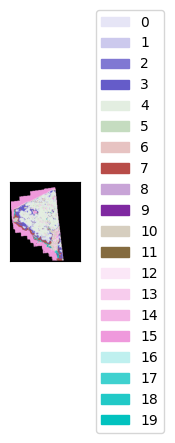

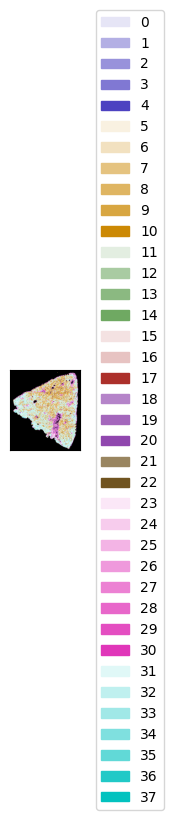

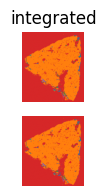

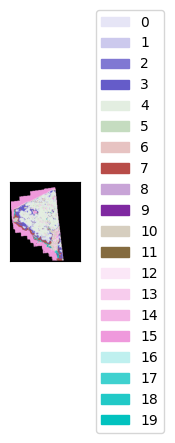

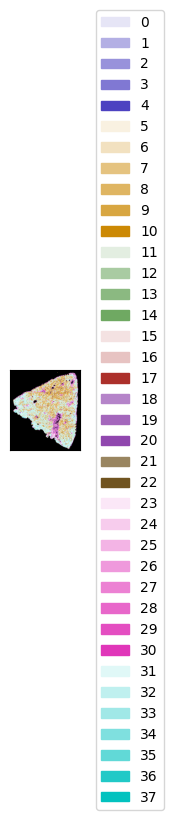

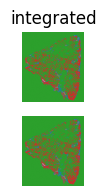

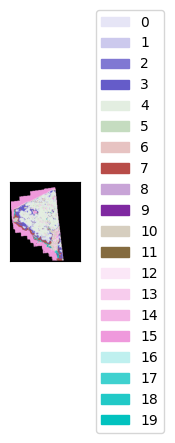

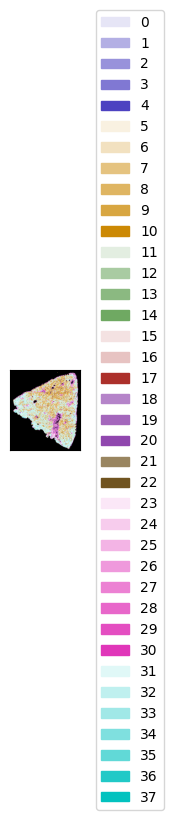

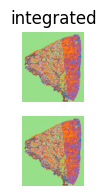

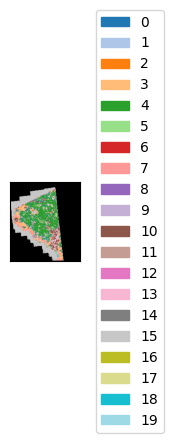

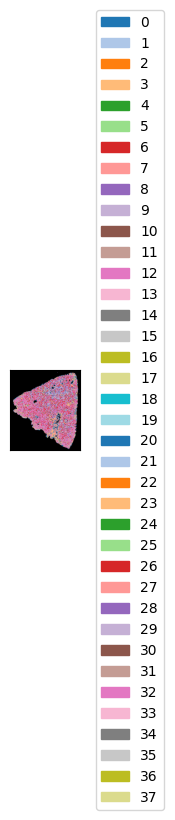

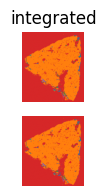

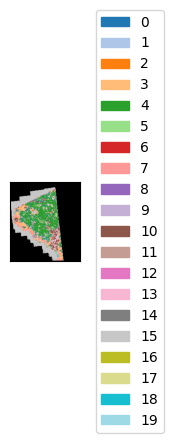

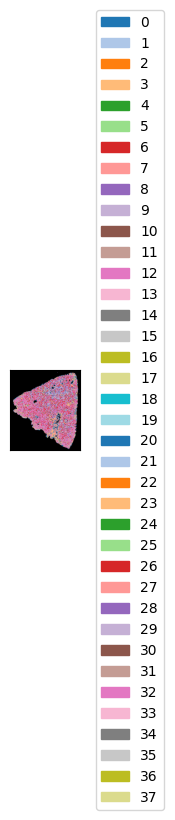

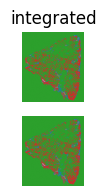

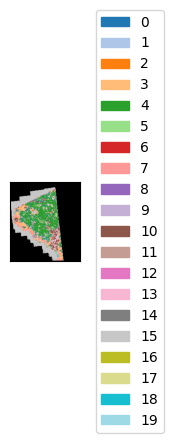

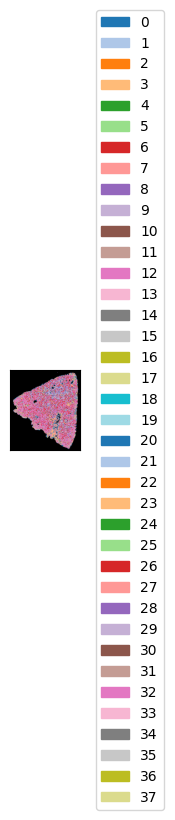

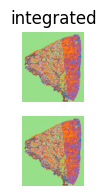

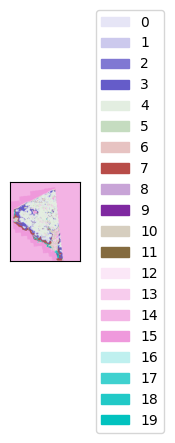

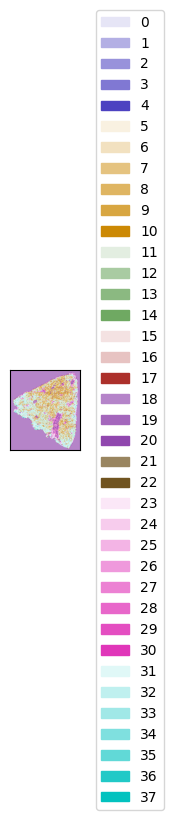

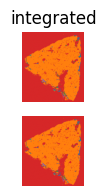

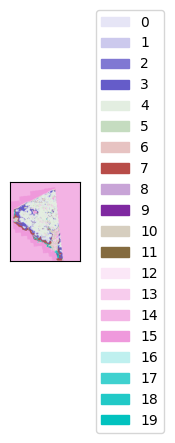

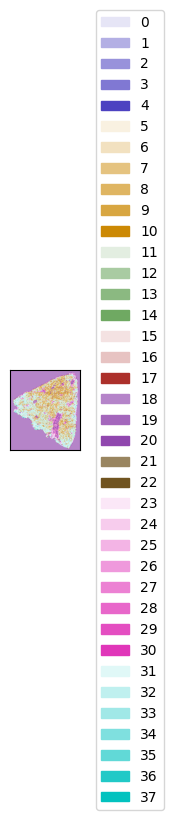

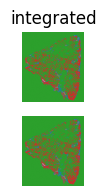

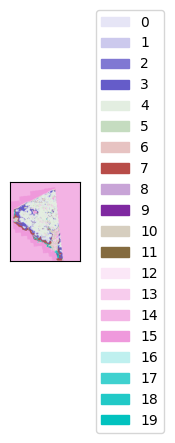

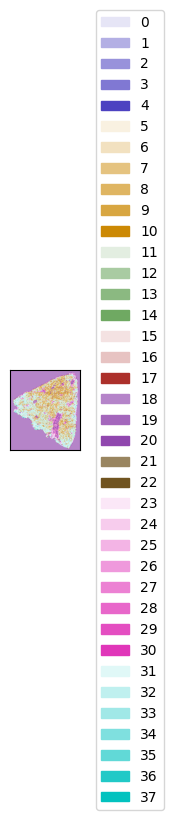

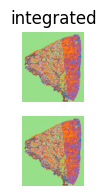

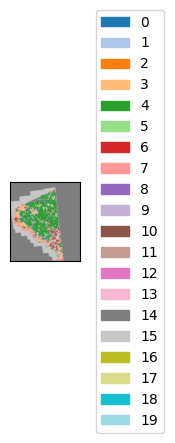

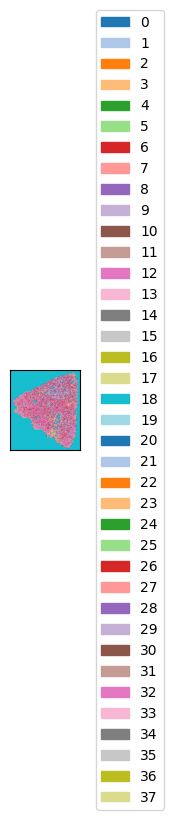

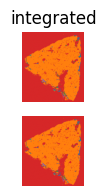

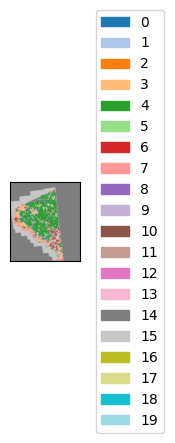

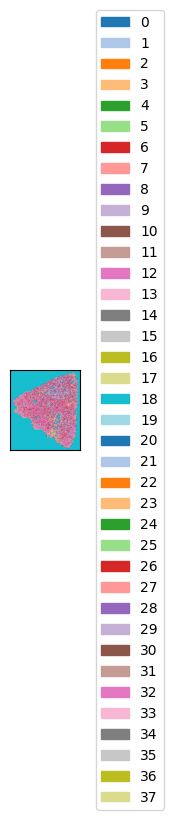

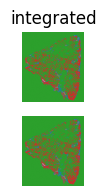

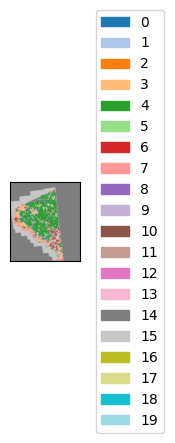

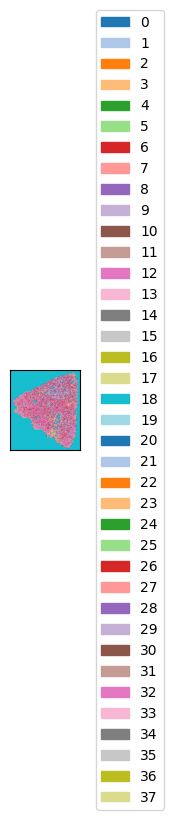

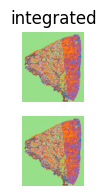

In [66]:
def save_nbhds(discard_max=False, use_hierarchy=True):
    for level in range(mushroom.num_levels):
        data = pickle.load(
            open(os.path.join(run_dir, case, 'mushroom_50res', f'nbhd_volumes_l{level}.pkl'), 'rb')
        )
        dtype_to_volume = data['probs']
        dtype_to_volume_labels = data['labeled']

        for dtype in mushroom.dtypes:
            mushroom.display_clusters(dtype, discard_max=discard_max, use_hierarchy=use_hierarchy)
            plt.savefig(os.path.join(fig_dir, f'nbhd_{dtype}_l{level}_bckrd{discard_max}_hcmap{use_hierarchy}.svg'), dpi=300)
            plt.savefig(os.path.join(fig_dir, f'nbhd_{dtype}_l{level}_bckrd{discard_max}_hcmap{use_hierarchy}.png'), dpi=300)
            plt.savefig(os.path.join(fig_dir, f'nbhd_{dtype}_l{level}_bckrd{discard_max}_hcmap{use_hierarchy}.tif'), dpi=300)

        mushroom.display_volumes(dtype_to_volume={k:v for k, v in dtype_to_volume_labels.items() if k=='integrated'},
                                 positions=mushroom.section_positions)

        plt.savefig(os.path.join(fig_dir, f'nbhd_integrated_l{level}_bckrd{discard_max}.svg'), dpi=300)
        plt.savefig(os.path.join(fig_dir, f'nbhd_integrated_l{level}_bckrd{discard_max}.png'), dpi=300)
        plt.savefig(os.path.join(fig_dir, f'nbhd_integrated_l{level}_bckrd{discard_max}.tif'), dpi=300)

fig_dir = os.path.join(export_dir, 'figures')
Path(fig_dir).mkdir(parents=True, exist_ok=True)

save_nbhds(discard_max=True, use_hierarchy=True)
save_nbhds(discard_max=True, use_hierarchy=False)
save_nbhds(discard_max=False, use_hierarchy=True)
save_nbhds(discard_max=False, use_hierarchy=False)


In [65]:
import shutil
fp = os.path.join(run_dir, case, 'mushroom_50res', f'outputs.pkl')
shutil.copy(fp, os.path.join(export_dir, 'outputs.pkl'))

'/data/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/exports/outputs.pkl'

directory structure

outputs.pkl

* pickle file that can be loaded into python that contains the mushroom results. Useful if you need the underlying pixel level data

section_metadata.txt

* metadata for the sections included in the mushroom run

barcodes_to_nbhds/

* Contains files with the following naming scheme: <section_id>_<dtype>_barcode_to_nbhds.txt
* The files are tables with the following columns
    * cell_id - cell or spot barcode
    * nbhd_LEVEL - data-type specific neighborhood for the given level (i.e. if it is a xenium section it will be a xenium neighborhood, if it was a codex section it will be a codex neighborhood, etc.)
    * nbhd_crossdtype_DTYPE_LEVEL - cross data-type neighborhood, where the neighborhood data type is the data type specified by the column


figures/

* contains .svg, .png, and .tif figures displaying the discovered neighborhoods
* files are named nbhd_DTYPE_lLEVEL_BACKGROUNDMETHOD_CMAPMETHOD 
    * background_method when True means largest neighborhood is set to white/transparent (usually the background neighborhood)
    * cmap_method when True means that neighborhoods are colored based on neighborhood hierarchy, when false they are colored by seaborn tab20 colors
    
    





















